# Assignment 1
****
**Code Author:** Irsh Vijay (21EC39055)

### Mandatory Imports

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading Images

In [2]:
img1 = np.asarray(Image.open('0001.png').convert('L'))
img2 = np.asarray(Image.open('0002.png').convert('L'))

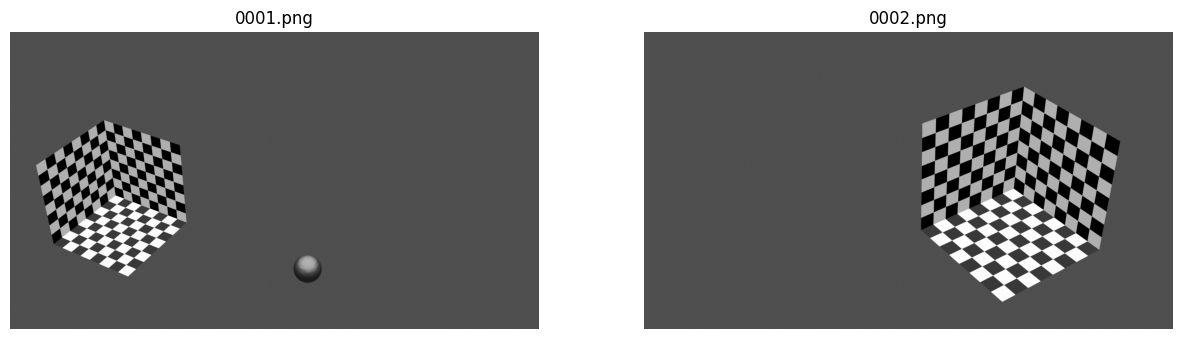

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('0001.png')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title('0002.png')
plt.axis('off')
plt.show()

### Calculating Homography

In [4]:
records = [
    {'real_world': (0, 0, 8), 'img1': (324, 342), 'img2': (202, 1379)},
    {'real_world': (0, 0, 0), 'img1': (596, 383), 'img2': (571, 1342)},
    {'real_world': (8, 0, 0), 'img1': (772, 159), 'img2': (721, 1006)},
    {'real_world': (8, 0, 8), 'img1': (487, 95), 'img2': (335, 1011)},
    {'real_world': (0, 8, 8), 'img1': (415, 617), 'img2': (399, 1728)},
    {'real_world': (0, 8, 0), 'img1': (694, 640), 'img2': (793, 1652)},
]

df = pd.DataFrame.from_records(records)
df.to_csv('homography.csv', index=False)
df

,real_world,img1,img2
0,"(0, 0, 8)","(324, 342)","(202, 1379)"
1,"(0, 0, 0)","(596, 383)","(571, 1342)"
2,"(8, 0, 0)","(772, 159)","(721, 1006)"
3,"(8, 0, 8)","(487, 95)","(335, 1011)"
4,"(0, 8, 8)","(415, 617)","(399, 1728)"
5,"(0, 8, 0)","(694, 640)","(793, 1652)"


In [5]:
def plot_points(img, points, marker='ro', plot_img=True):
    if plot_img:
        plt.imshow(img, cmap='gray')
    for x, y in points:
        plt.plot(y, x, marker)

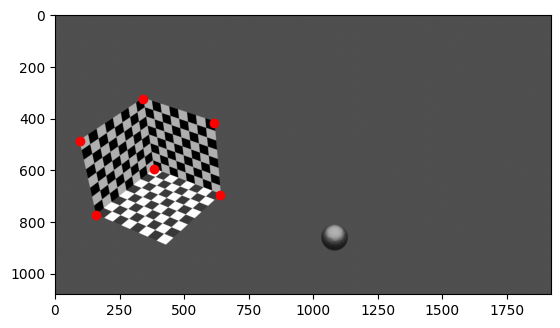

In [6]:
plot_points(img1, df['img1'].values)

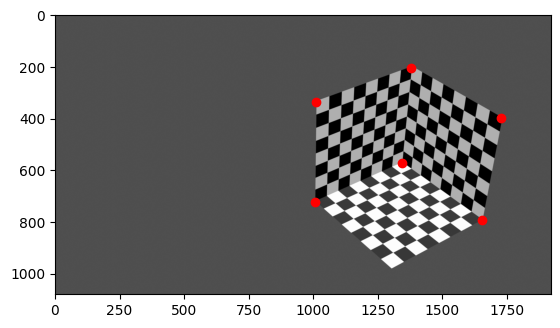

In [7]:
plot_points(img2, df['img2'].values)

To compute `H`: 

$H \begin{bmatrix} x_1 \\ y_1 \\ 1 \end{bmatrix} = \begin{bmatrix} x_2 \\ y_2 \\ 1 \end{bmatrix}$
\
\
$\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix} \begin{bmatrix} x_1 \\ y_1 \\ 1 \end{bmatrix} = \begin{bmatrix}  x_2 \\ y_2 \\ 1 \end{bmatrix}$
\
\
Which leads to: \
$
\begin{aligned}
h_1 x_1 + h_2 y_1 + h_3 &= x_2 \\
h_4 x_1 + h_5 y_1 + h_6 &= y_2 \\
h_7 x_1 + h_8 y_1 + h_9 &= 1
\end{aligned}
$

In [8]:
A = []

for record in df.itertuples():
    x1, y1 = record.img1
    x2, y2 = record.img2

    A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
    A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

A = np.array(A)

In [9]:
def SVD(A):
    eigenvalues_ATA, eigenvectors_ATA = np.linalg.eig(A.T @ A)
    eigenvalues_AAT, eigenvectors_AAT = np.linalg.eig(A @ A.T)

    idx = eigenvalues_ATA.argsort()[::-1]
    eigenvalues_ATA = eigenvalues_ATA[idx]
    eigenvectors_ATA = eigenvectors_ATA[:, idx]

    idx = eigenvalues_AAT.argsort()[::-1]
    eigenvalues_AAT = eigenvalues_AAT[idx]
    eigenvectors_AAT = eigenvectors_AAT[:, idx]

    s = np.sqrt(eigenvalues_ATA)

    U = eigenvectors_AAT
    V = eigenvectors_ATA

    return U, s, V.T

def left_null_vector(A):
    U, S, Vt = SVD(A)
    left_null_space = U[:, -1]
    return left_null_space

def right_null_vector(A):
    U, S, Vt = SVD(A)
    null_space = Vt.T[:, -1]
    return null_space

def homogenize(x):
    return x / x.flatten()[-1]

def solve_svd(A, output_shape=(3, 3)):
    h = right_null_vector(A)
    H = h.reshape(output_shape)
    # H = homogenize(H)
    return H

H = homogenize(solve_svd(A, (3, 3)))

In [10]:
H

array([[ 1.31676119e+00,  2.45814040e-01, -3.20647338e+02],
       [-2.52527524e-01,  1.08851861e+00,  1.04681984e+03],
       [ 5.66534751e-05, -1.43131317e-04,  1.00000000e+00]])

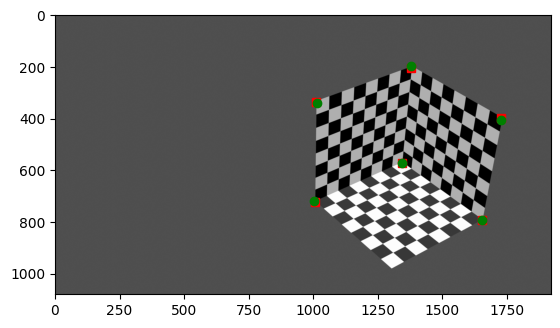

In [11]:
image1_points = df['img1'].values

inferred_image2_points = []
for x1, y1 in image1_points:
    x2, y2, _ = H @ [x1, y1, 1]
    inferred_image2_points.append((x2 / _ , y2 / _))

inferred_image2_points = np.array(inferred_image2_points)

plot_points(img2, df['img2'].values, marker='rs')
plot_points(img2, inferred_image2_points, marker='go')

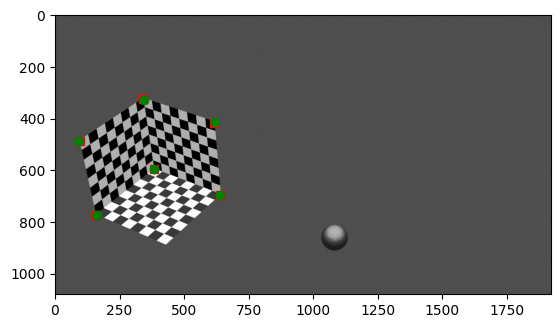

In [12]:
image2_points = df['img2'].values

inferred_image1_points = []
for x2, y2 in image2_points:
    x1, y1, _ = np.linalg.inv(H) @ [x2, y2, 1]
    inferred_image1_points.append((x1 / _ , y1 / _))

inferred_image1_points = np.array(inferred_image1_points)

plot_points(img1, df['img1'].values, marker='rs')
plot_points(img1, inferred_image1_points, marker='go')

### Calculating Perspective

In [13]:
A1 = []
A2 = []

for record in df.itertuples():
    X, Y, Z = record.real_world
    u1, v1 = record.img1
    u2, v2 = record.img2

    A1.append([X, Y, Z, 1, 0, 0, 0, 0, -u1*X, -u1*Y, -u1*Z, -u1])
    A1.append([0, 0, 0, 0, X, Y, Z, 1, -v1*X, -v1*Y, -v1*Z, -v1])

    A2.append([X, Y, Z, 1, 0, 0, 0, 0, -u2*X, -u2*Y, -u2*Z, -u2])
    A2.append([0, 0, 0, 0, X, Y, Z, 1, -v2*X, -v2*Y, -v2*Z, -v2])

A1 = np.array(A1)
A2 = np.array(A2)

P1 = solve_svd(A1, output_shape=(3, 4))
P2 = solve_svd(A2, output_shape=(3, 4))

In [14]:
xy_grid = [[x, y, 0, 1] for x in range(9) for y in range(9)]
xy_grid = np.array(xy_grid)

pixel_grid_xy1 = xy_grid @ P1.T
pixel_grid_xy2 = xy_grid @ P2.T

pixel_grid_xy1 = pixel_grid_xy1[:, :2] / pixel_grid_xy1[:, 2, None]
pixel_grid_xy2 = pixel_grid_xy2[:, :2] / pixel_grid_xy2[:, 2, None]

In [15]:
yz_grid = [[0, y, z, 1] for y in range(9) for z in range(9)]
yz_grid = np.array(yz_grid)

pixel_grid_yz1 = yz_grid @ P1.T
pixel_grid_yz2 = yz_grid @ P2.T

pixel_grid_yz1 = pixel_grid_yz1[:, :2] / pixel_grid_yz1[:, 2, None]
pixel_grid_yz2 = pixel_grid_yz2[:, :2] / pixel_grid_yz2[:, 2, None]

In [16]:
xz_grid = [[x, 0, z, 1] for x in range(9) for z in range(9)]
xz_grid = np.array(xz_grid)

pixel_grid_xz1 = xz_grid @ P1.T
pixel_grid_xz2 = xz_grid @ P2.T

pixel_grid_xz1 = pixel_grid_xz1[:, :2] / pixel_grid_xz1[:, 2, None]
pixel_grid_xz2 = pixel_grid_xz2[:, :2] / pixel_grid_xz2[:, 2, None]

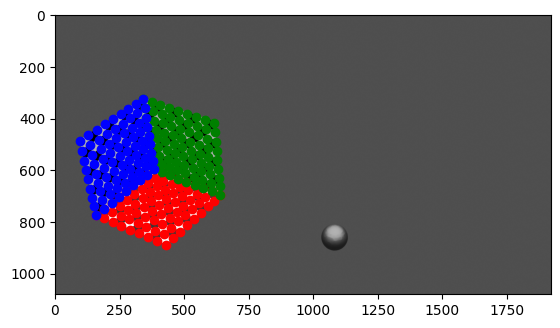

In [17]:
plot_points(img1, pixel_grid_xy1, 'ro')
plot_points(img1, pixel_grid_yz1, 'go')
plot_points(img1, pixel_grid_xz1, 'bo')

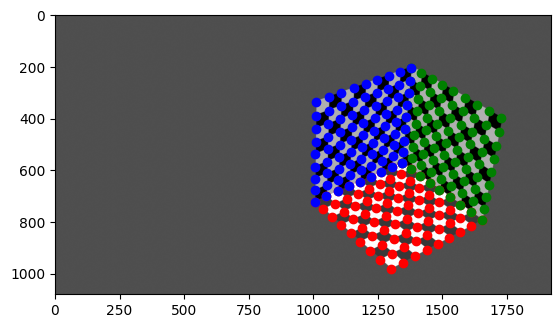

In [18]:
plot_points(img2, pixel_grid_xy2, 'ro')
plot_points(img2, pixel_grid_yz2, 'go')
plot_points(img2, pixel_grid_xz2, 'bo')

In [19]:
C1 = homogenize(right_null_vector(P1))
C2 = homogenize(right_null_vector(P2))

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_90060/2687413651.py:13: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(eigenvalues_ATA)


In [20]:
C1 # 40, 40, 40

array([39.21683068, 39.0014018 , 39.3398343 ,  1.        ])

In [21]:
C2 # 30, 30, 30

array([29.57675825, 29.62084357, 29.64639757,  1.        ])

In [22]:
from scipy.linalg import rq

K1, R1 = rq(P1[:, :3])

In [23]:
e1 = homogenize(P1 @ C2)

In [24]:
e2 = homogenize(P2 @ C1)

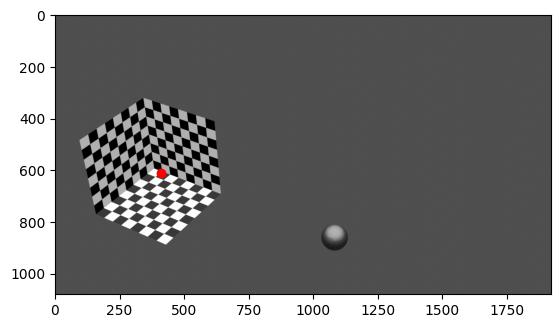

In [25]:
plot_points(img1, [e1[:2]], 'ro')

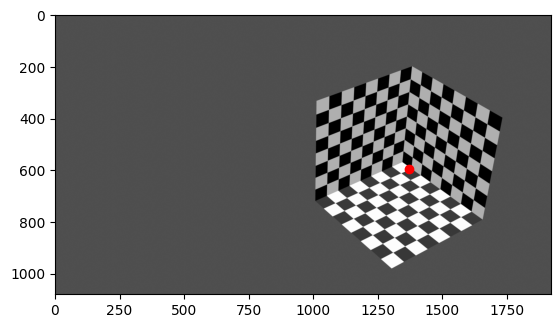

In [26]:
plot_points(img2, [e2[:2]], 'ro')

In [27]:
F = np.cross(e2, np.identity(3)) @ P2 @ np.linalg.pinv(P1)
F = homogenize(F)

In [28]:
def check_epipolar_constraint(F, p1, p2):
    x1 = np.array([*p1, 1])
    x2 = np.array([*p2, 1])
    return abs(x1.T @ F @ x2) < 1e-4

for record in df.itertuples():
    assert check_epipolar_constraint(F, record.img2, record.img1)
    assert check_epipolar_constraint(F.T, record.img1, record.img2)

print('All epipolar constraints are satisfied')

All epipolar constraints are satisfied


In [29]:
homogenize(e2 @ F)

array([-0.00000000e+00,  7.32421875e-04,  1.00000000e+00])

In [30]:
homogenize(F @ e1)

array([-0.0130602 ,  0.00494855,  1.        ])

In [31]:
def get_epipolar_line(F, p1):
    x1 = np.array([*p1, 1])
    l2 = F @ x1
    return l2

def plot_epipolar_line(img, F, H, pt):
    l2 = get_epipolar_line(F, pt)
    e = homogenize(left_null_vector(F))

    x = np.arange(0, img.shape[0])
    y = (-l2[2] - l2[0] * x) / l2[1]
    valid_indices = (y >= 0) & (y < img.shape[1])
    x = x[valid_indices]
    y = y[valid_indices]

    plt.imshow(img, cmap='gray')
    plt.plot(y, x, alpha=0.5)
    pt_on_img = H @ [*pt, 1]
    pt_on_img = pt_on_img[:2] / pt_on_img[2]
    plt.plot(pt_on_img[1], pt_on_img[0], 'go')

    plt.plot(e[1], e[0], 'go')

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_90060/2687413651.py:13: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(eigenvalues_ATA)


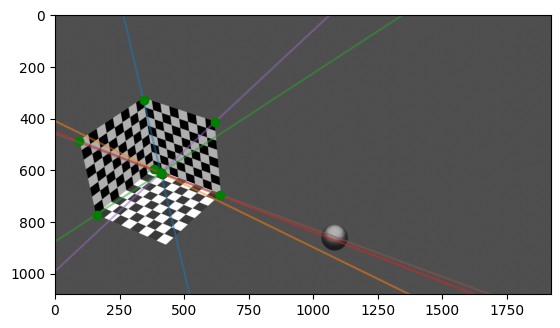

In [32]:
for img_idx in range(len(df)):
    plot_epipolar_line(img1, F.T, np.linalg.inv(H), df['img2'].values[img_idx])

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_90060/2687413651.py:13: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(eigenvalues_ATA)


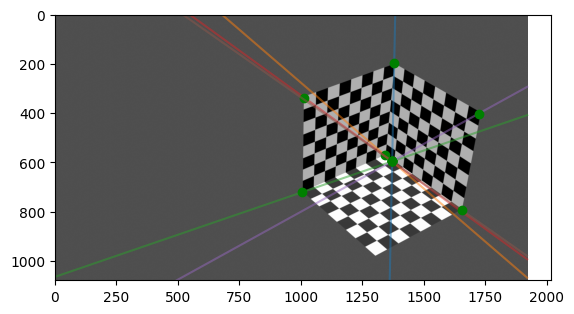

In [33]:
for img_idx in range(len(df)):
    plot_epipolar_line(img2, F, H, df['img1'].values[img_idx])

### Image Stitching

In [34]:
warped_points = np.zeros((img2.shape[0]*2, img2.shape[1]*2))

for i in range(img1.shape[0]):
    for j in range(img1.shape[1]):
        x, y, _ = H @ [i, j, 1]
        x = int(x/_)
        y = int(y/_)
        if x >= 0 and x < 2 * img2.shape[0] and y >= 0 and y < 2 * img2.shape[1]:
            warped_points[x, y] = img1[i, j]

In [35]:
warped_points[:img2.shape[0], :img2.shape[1]] += img2/2

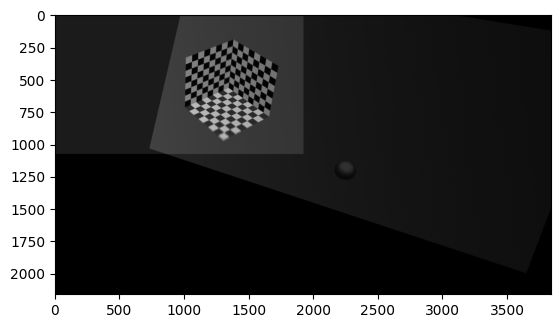

In [36]:
plt.imshow(warped_points, cmap='gray')